In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2

In [2]:
labels = os.listdir("../Downloads/Driver-Drowsiness-Dataset/train")
#labels

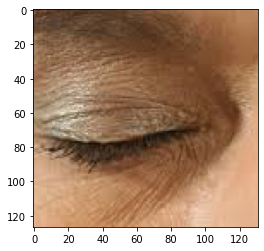

In [4]:
#closed
import matplotlib.pyplot as plt
plt.imshow(plt.imread("../Downloads/Driver-Drowsiness-Dataset/train/Closed/_10.jpg"))

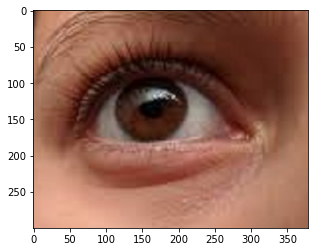

In [5]:
#open
import matplotlib.pyplot as plt
plt.imshow(plt.imread("../Downloads/Driver-Drowsiness-Dataset/train/Open/_100.jpg"))

In [8]:
#image array (yawn)
a = plt.imread("../Downloads/Driver-Drowsiness-Dataset/train/yawn/10.jpg")
#image shape
a.shape


(480, 640, 3)

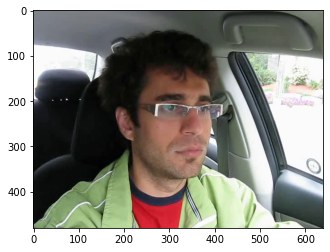

In [9]:
#no yawn
plt.imshow(plt.imread("../Downloads/Driver-Drowsiness-Dataset/train/no_yawn/1028.jpg"))

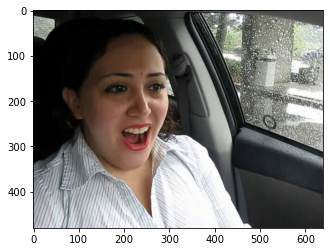

In [10]:
#yawn
plt.imshow(plt.imread("../Downloads/Driver-Drowsiness-dataset/train/yawn/104.jpg"))

In [13]:
#get rid of background in yawns
def face_for_yawn(direc="../Downloads/Driver-Drowsiness-Dataset/train", face_cas_path="../Downloads/prediction-images/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


In [16]:
#get rid of backgrounds in open/closed
def get_data(dir_path="../Downloads/Driver-Drowsiness-Dataset/train/", face_cas="../Downloads/prediction-images/haarcascade_frontalface_default.xml", eye_cas="../Downloads/prediction-images/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

data_train= get_data()

2
3


In [18]:
#extend data and convert array
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

#new variable to store 
new_data= append_data()

0
1
2
3


<ipython-input-18-a31796cb5395>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yaw_no)


In [19]:
#separate label and features
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [20]:
#need to reshape the data

X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [21]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [22]:
#label the array
y= np.array(y)

In [25]:
#split the train and test data 
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

#len(X_test)
y_test

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0]])

In [28]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras


In [32]:
#data augmentation
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [33]:
#create model
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [34]:
#model the model
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
43/43 [==============================] - 180s 4s/step - loss: 1.1235 - accuracy: 0.5019 - val_loss: 0.6408 - val_accuracy: 0.7249
Epoch 2/50
43/43 [==============================] - 212s 5s/step - loss: 0.5491 - accuracy: 0.7884 - val_loss: 0.4758 - val_accuracy: 0.8080
Epoch 3/50
43/43 [==============================] - 201s 5s/step - loss: 0.3911 - accuracy: 0.8330 - val_loss: 0.3444 - val_accuracy: 0.8685
Epoch 4/50
43/43 [==============================] - 207s 5s/step - loss: 0.3302 - accuracy: 0.8537 - val_loss: 0.2949 - val_accuracy: 0.8858
Epoch 5/50
43/43 [==============================] - 204s 5s/step - loss: 0.2949 - accuracy: 0.8708 - val_loss: 0.2926 - val_accuracy: 0.8875
Epoch 6/50
43/43 [==============================] - 215s 5s/step - loss: 0.2841 - accuracy: 0.8753 - val_loss: 0.2779 - val_accuracy: 0.8997
Epoch 7/50
43/43 [==============================] - 183s 4s/step - loss: 0.2712 - accuracy: 0.8842 - val_loss: 0.2500 - val_accuracy: 0.9066
Epoch 8/50
43

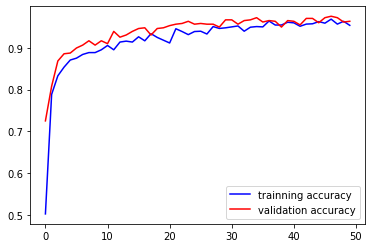

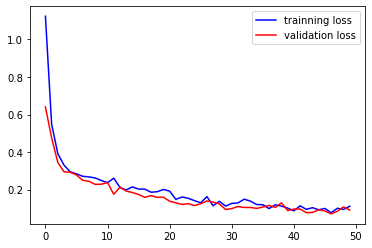

In [35]:
#plot history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [36]:
model.save("drowiness_new6.h5")

In [37]:
model.save("drowiness_new6.model")
#INFO:tensorflow:Assets written to: drowiness_new6.model/assets

INFO:tensorflow:Assets written to: drowiness_new6.model/assets


INFO:tensorflow:Assets written to: drowiness_new6.model/assets


In [42]:
#prediction

predict_x= model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

19/19 [==============================] - 20s 1s/step


In [44]:
prediction=classes_x.reshape(-1,1)



In [45]:
prediction.shape


(578, 1)

In [46]:
type(prediction)

numpy.ndarray

In [47]:
import numpy as np

n_values = np.max(prediction) + 1
pred=np.eye(n_values)[prediction]
pred

array([[[0., 0., 0., 1.]],

       [[0., 0., 0., 1.]],

       [[0., 0., 1., 0.]],

       ...,

       [[0., 0., 0., 1.]],

       [[0., 0., 1., 0.]],

       [[0., 0., 1., 0.]]])

In [48]:
print(y_test.shape)
print(pred.shape)
pred=np.reshape(pred, (578*1, 4))
pred

(578, 4)
(578, 1, 4)


array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [49]:
from sklearn.metrics import confusion_matrix,accuracy_score

#Generate the confusion matrix
cf_matrix=confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))
print(cf_matrix)
print(accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)))

[[ 47  15   1   0]
 [ 14  58   0   2]
 [  1   1 202  11]
 [  0   0   1 225]]
0.9204152249134948


[Text(0, 0.5, 'yawn'),
 Text(0, 1.5, 'no_yawn'),
 Text(0, 2.5, 'Closed'),
 Text(0, 3.5, 'Open')]

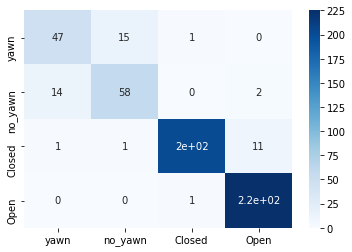

In [50]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.xaxis.set_ticklabels(['yawn','no_yawn','Closed','Open'])
ax.yaxis.set_ticklabels(['yawn','no_yawn','Closed','Open'])


In [51]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]


In [52]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.76      0.75      0.75        63
     no_yawn       0.78      0.78      0.78        74
      Closed       0.99      0.94      0.96       215
        Open       0.95      1.00      0.97       226

    accuracy                           0.92       578
   macro avg       0.87      0.87      0.87       578
weighted avg       0.92      0.92      0.92       578



In [53]:
#predicitng function
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="../Downloads/prediction-images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowiness_new6.h5")

In [54]:
#no_yawn
prediction = model.predict([prepare("../Downloads/Driver-Drowsiness-Dataset/train/no_yawn/1067.jpg")])
np.argmax(prediction)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 232ms/step


2

In [55]:
#closed
prediction = model.predict([prepare("../Downloads/Driver-Drowsiness-Dataset/train/Closed/_101.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 67ms/step


2